# [IAPR][iapr]: Lab 3 ‒  Classification


**Group ID:** xx

**Author 1 (sciper):** Student Name 1 (xxxxx)  
**Author 2 (sciper):** Student Name 2 (xxxxx)   
**Author 3 (sciper):** Student Name 3 (xxxxx)   

**Release date:** 19.04.2023  
**Due date:** 05.05.2023 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.


[iapr]: https://github.com/LTS5/iapr

--
## 0. Setup

In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this lab, we will use PyTorch. If you are not familiar with this library, [here](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html) is a quick tutorial of the basics.

In [37]:
# import platform
# print(platform.system())
# if platform.system() == "Darwin":
#     %pip install torch==1.12.1 torchvision==0.13.1
# else:
#     %pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html

In [38]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1 - Out-of-Distribution detection in colorectal cancer histology (12 points)

Colorectal cancer is one of the most widespread cancers for men and women. Diagnosis complemented with prognostic and predictive biomarker information is essential for patient monitoring and applying personalized treatments. A critical marker is the tumor/stroma ratio in unhealthy tissues sampled from the colon. The higher the ratio, the more invasive the cancer is. The degree of invasion is tightly linked to patient survial probability.

To measure the ratio, a pathologist needs to analyze the unhealthy tissue under a microscope and estimate it from a look. As the number of samples to analyze is huge and estimations are only sometimes precise, automatic recognition of the different tissue types in histological images has become essential. Such an automatic process requires the development of a multi-class classifier to identify the numerous tissues. As shown below, they are usually 8 tissue types to categorize: TUMOR, STROMA, LYMPHO (lymphocytes), MUCOSA, COMPLEX (complex stroma), DEBRIS, ADIPOSE and EMPTY (background).

<br />
<br />
<figure>
    <img src="../data/lab-03-data/part1/kather16.svg" width="1100">
    <center>
    <figcaption>Fig1: Collection of tissue types in colorectal cancer histology (Kather-16)</figcaption>
    </center>
</figure>
<br />
<br />


Up to this day, state-of-the-art methods use deep-learning-based supervised learning methods. A downfall of such an approach is the necessity to access a well-annotated training dataset. In histology, annotating data is difficult. It is time-consuming and requires the expertise of pathologists. Moreover, the annotator must label every tissue type while only two (TUMOR and STROMA) are interesting. 


Consequently, we propose another approach. In order to make the annotation task less tedious, we ask the annotator to label only the tissues of interest and dump the others. Then, we must train a binary classifier to automatically recognize these tissues at test time. In this part, you will implement the proposed approach.

### 1.1 Binary classifier with Mahalanobis distance (3 points)

Based on the abovementioned process, your task is to build a model that recognizes TUMOR (Label 0) and STROMA (Label 1) tissue types. Your model will be supervised by a training dataset containing TUMOR and STROMA annotations; note that all other tissues have been dropped.
We will not ask you to train a deep-learning-based binary classifier from scratch. Instead, we provide excellent features (descriptors) of the images we extracted from a visual foundation model. (Note: As the nature of the foundation model is not part of this lecture, feel free to ask TAs if you are curious).

Run the cell below to extract the provided train and test dataset. Each image is represented by a 768-d feature vector extracted from a visual foundation model. The train and test datasets contain feature vectors of 878 and 186 images respectively.

In [39]:
import torch 

# Label mapping
label_to_classname = {0 : "TUMOR", 1 : "STROMA"}

# Train features and labels
train_features = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_train_features.pth"))
train_labels = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_train_labels.pth"))

# Test features and labels
test_features = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test_features.pth"))
test_labels = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test_labels.pth"))

test_features.shape

torch.Size([186, 768])

**Task 1 (2.5 points)** Based on the training features (```train_features```) and training labels (```train_labels```), classify the test features (```test_features```) using minimum Mahalanobis distance.

*Note:* You are not allowed to use any prebuilt Mahalanobis distance function. Additionally, ```torch.cov``` is not defined to compute the covariance matrix. You can use ```sklearn.covariance.LedoitWolf``` instead.

In [40]:
### Task 1

from sklearn.covariance import LedoitWolf
import numpy as np

def malahanobis_binary_classification(train_features, train_labels, test_features):
    ''' Classifier that returns classifies testing points and their malahanobis distance to the closet class '''
    
    # Get the covariance matrix for each class
    class0_cov, class1_cov = [LedoitWolf().fit(train_features[train_labels==i]).covariance_ for i in [0,1]]
    
    # Compute once for all the inverse of the covariance matrices for the malahanobis distance computation
    class0_cov_inv, class1_cov_inv = np.linalg.inv(class0_cov), np.linalg.inv(class1_cov)
    
    # Get the mean for each class
    class0_mean, class1_mean = [torch.mean(train_features[train_labels==i], dim=0, keepdim=False) for i in [0,1]]
    
    # Classifiy each data point
    pred_labels = []
    dist = []
    for x in test_features:
        
        # Compute the malahanobis distance to each class
        dist0 = (np.sqrt((x-class0_mean).T @ class0_cov_inv @ (x-class0_mean))) # distance to class 0
        dist1 =(np.sqrt((x-class1_mean).T @ class1_cov_inv @ (x-class1_mean)))  # distance to class 1
        
        # Store the minimum distance
        dist.append(min(dist0, dist1))
        
        # Classify the data point to the closest class
        pred_labels.append(0 if dist0 < dist1 else 1)
    
    return np.array(pred_labels).astype(int), np.array(dist)

pred_labels, _ = malahanobis_binary_classification(train_features, train_labels, test_features)

**Task 2 (0.5 points)** Compute the accuracy of your predictions with the test labels (```test_labels```).

In [41]:
### Task 2

# Accuracy = (number of correct predictions) / (total number of predictions) or (TP + TN) / (TP + TN + FP + FN)
accuracy = (pred_labels==test_labels).sum()/len(test_labels)
print("Accuracy: {:.2f}".format(accuracy))


Accuracy: 0.98


### 1.2 Out-of-Distribution detection with Mahalanobis distance (3 points)

You will note that the test you run above is not really realistic. Like the training set, it contains only the TUMOR and STROMA tissue types. Nevertheless, at test time, the other tissues (Label -1) are also present and cannot be filtered by hand. Moreover, they cannot be recognized by the model as they are out of the training distribution (It is the consequence of the laziness of the annotators ;)). For this reason, it is essential to filter them out. This task is called Out-of-Distribution (OoD) detection. 

A simple way to do OoD detection is to compute for every test example an OoD-ness score which should be low for In-Distribution (ID) examples and high for OoDs. Then we define a threshold from which every example with an OoD-ness lying above is discarded, and those lying below are forwarded to the model for prediction. An example of OoD-ness score is the minimum Mahalanobis distance.

Run the cell below to load a new test set containing OoD examples. It has 186 ID and 558 OoD examples.

In [42]:
label_to_classname_w_ood = {0 : "TUMOR", 1 : "STROMA", -1 : "OoD"}

# Test features and labels with OoD tissues
test_features_w_ood = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test2_features.pth"))
test_labels_w_ood = torch.load(os.path.join(data_base_path, data_folder,"part1/k16_test2_labels.pth"))

test_features_w_ood.shape

torch.Size([744, 768])

**Task 1 (0.5 point)** Why do you think the minimum Mahalanobis distance is a good OoD-ness score?

**Answer:** If a data point is far from the training data points, it might highly be a outlier. Knowing that the Mahalanobis distance takes into account the general trend of the training points (using the covariance matrix and the mean vector), it can easily detect if a datapoint follows the tumor distribution or the stroma distribution, or if it's an Out of Distribution point.

**Task 2 (0.5 point)** Compute the minimum Mahalanobis distance for every test examples in ```test_features_w_ood``` with respect to the training features (```train_features```).

In [43]:
### Task 2
    
_, dist_w_ood = malahanobis_binary_classification(train_features, train_labels, test_features_w_ood)

**Task 3 (0.5 point)** Plot a histogram to show the difference between the Mahalanobis distance of TUMOR, STROMA and OoD tissue types and comment on what you observe.

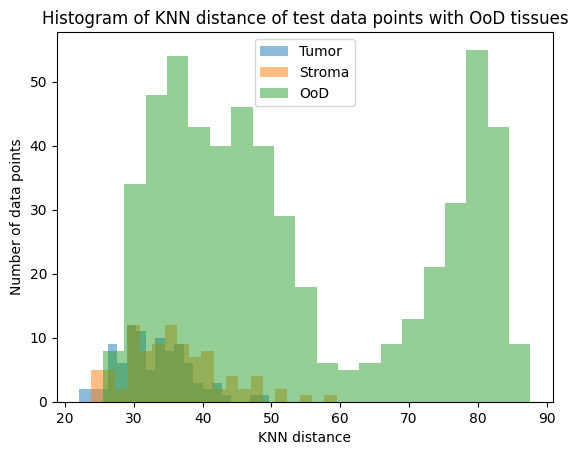

In [44]:
### Task 3

import matplotlib.pyplot as plt

# Plot histogram of distances with different colors for each class
plt.hist(dist_w_ood[test_labels_w_ood==0], bins=20, alpha=0.5, label='Tumor')
plt.hist(dist_w_ood[test_labels_w_ood==1], bins=20, alpha=0.5, label='Stroma')
plt.hist(dist_w_ood[test_labels_w_ood==-1], bins=20, alpha=0.5, label='OoD')

# Add legend and other stuff
plt.legend()
plt.title("Histogram of KNN distance of test data points with OoD tissues")
plt.xlabel("KNN distance")
plt.ylabel("Number of data points")
plt.show()


**Observations:** Overall, the tumor and stroma testing points are closer to either the tumor distribution or stroma distribution. Concerning the OoD points, it seems there is a big gap: some points are quite close to the distributions as well, whereas some are really far. The further points can easily be detected and filtered out, but we will have difficulties filtering out the closest OoD points without filtering out true positives (tumor or stroma). 

**Task 4 (1 point)** Find a threshold on the Mahalanobis distance such that 95% of the OoD examples are filtered out. How much TUMOR and STROMA have also been filtered out?

In [45]:
### Task 4

# Get the minimum distance that classifies 95% of the OoD tissues as OoD
dist_thresh = np.percentile(dist_w_ood[test_labels_w_ood==-1], 5)
print("Distance threshold: {:.2f}".format(dist_thresh))

# How much class0 and class1 have been classified as OoD too
tumor_filtered_out = np.sum((test_labels_w_ood==0) & (dist_w_ood>dist_thresh))/np.sum(test_labels_w_ood==0)
print("Tumor filtered out: {:.2f}%".format(tumor_filtered_out*100))
stroma_filtered_out = np.sum((test_labels_w_ood==1) & (dist_w_ood>dist_thresh))/np.sum(test_labels_w_ood==1)
print("Stroma filtered out: {:.2f}%".format(stroma_filtered_out*100))


Distance threshold: 30.77
Tumor filtered out: 61.29%
Stroma filtered out: 74.19%


**Task 5 (0.5 point)** Assign prediction -1 to filtered out examples and compute the average class-wise accuracy of your prediction with test labels (```test_labels_w_ood```). Is it satisfactory?

In [46]:
### Task 5

# First assign each label to a class
pred_labels_w_ood, dist_w_ood = malahanobis_binary_classification(train_features, train_labels, test_features_w_ood)

# Then remove the points that are too far from the closest class
pred_labels_w_ood[dist_w_ood>dist_thresh] = -1

In [47]:
# Class-wise accuracy : (TP + TN) / (TP + TN + FP + FN)
TP_tumor = np.sum((test_labels_w_ood==0) & (pred_labels_w_ood==0))
TN_tumor = np.sum((test_labels_w_ood!=0) & (pred_labels_w_ood!=0))
accuracy_tumor = (TP_tumor + TN_tumor) / len(test_labels_w_ood)
print("Tumor accuracy: {:.2f}".format(accuracy_tumor))

TP_stroma = np.sum((test_labels_w_ood==1) & (pred_labels_w_ood==1))
TN_stroma = np.sum((test_labels_w_ood!=1) & (pred_labels_w_ood!=1))
accuracy_stroma = (TP_stroma + TN_stroma) / len(test_labels_w_ood)
print("Stroma accuracy: {:.2f}".format(accuracy_stroma))

# Average class-wise accuracy
accuracy = (accuracy_tumor + accuracy_stroma) / 2
print("Mean accuracy: {:.2f}".format(accuracy))

Tumor accuracy: 0.89
Stroma accuracy: 0.91
Mean accuracy: 0.90


### 1.3 Out-of-distribution detection with k-NN classifier (6 points)

The visual foundation models are known to be very good k-NN classifiers. It motivates us to implement a k-NN classifier to recognize TUMOR and STROMA. Moreover, k-NN distance is a good OoD-ness score and suits our task.

**Task 1 (2 points)** Based on the training features (```train_features```) and training labels (```train_labels```), classify the test features (```test_features```) using a k-NN classifier. Then report the accuracy of your predictions with the test labels (```test_labels```).

*Note:* The choice of `k` is up to you.

In [48]:
### Task 1

def KNN_binary_classifier(train_features, train_labels, test_features, k):
    ''' Classifier that returns the class of the k closest training points and the distance to the closest training point'''
    
    # Classifiy each testing point
    pred_labels = []
    dist = []
    for x in test_features:
        
        # Compute the distance to each training point
        dists = np.array([torch.norm(x-train_features[i]) for i in range(len(train_features))])
        
        # Get the k closest training points
        k_closest = np.argsort(dists)[:k]
        
        # Get the classes of the k closest training points
        k_closest_labels = train_labels[k_closest]
        
        # If les than half of the k closest training points are from class 1, classify the data point to class 0, else 1
        pred_labels.append(0 if k_closest_labels.sum() < k/2 else 1)
        
        # Defines the KNN distance as the mean distance to the K nearest neighbors (for OoD-ness score) 
        dist.append(np.mean(dists[k_closest]))
    
    return np.array(pred_labels).astype(int), np.array(dist)

# Get the predicted labels
pred_labels, _ = KNN_binary_classifier(train_features, train_labels, test_features, 7)

# Get the accuracy, same as before
accuracy = (pred_labels==test_labels).sum()/len(test_labels)
print("Accuracy: {:.2f}".format(accuracy))

Accuracy: 0.99


**Task 2 (2 points)** Perform OoD detection on the test features (```test_features_w_ood```) using a k-NN distance based OoD-ness score. Find a threshold on your OoD-ness score such that 95% of the OoD examples are filtered out. How much TUMOR and STROMA have also been filtered out? Finally, assign prediction -1 to filter out examples and compute the average class-wise accuracy of your prediction with test labels (```test_labels_w_ood```).

*Note:* The OoD-ness is based on the distance to the k-nearest neighbors. The formulation is up to you. You have to justify your choice.

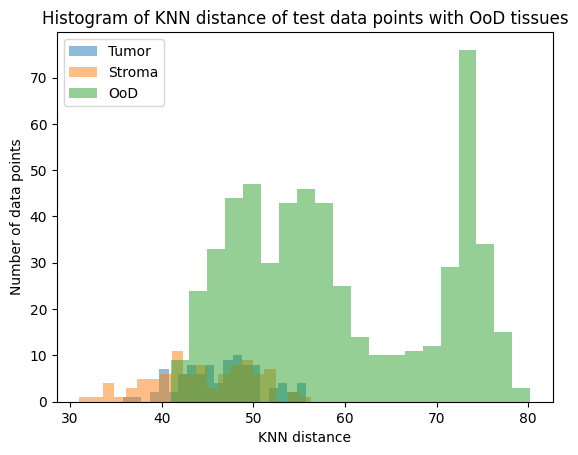

Distance threshold: 44.38
Tumor filtered out: 69.89%
Stroma filtered out: 48.39%
Tumor accuracy: 0.90
Stroma accuracy: 0.92
Mean accuracy: 0.91


In [53]:
### Task 2

# Same as for the malahanobis OoD-ness score:

# 1. Get the distances for each point
k = 7
pred_labels_w_ood, dist_w_ood = KNN_binary_classifier(train_features, train_labels, test_features_w_ood, k)

# 2. Plot histogram of distances with different colors for each class
plt.hist(dist_w_ood[test_labels_w_ood==0], bins=20, alpha=0.5, label='Tumor')
plt.hist(dist_w_ood[test_labels_w_ood==1], bins=20, alpha=0.5, label='Stroma')
plt.hist(dist_w_ood[test_labels_w_ood==-1], bins=20, alpha=0.5, label='OoD')
# Add legend and other stuff
plt.legend()
plt.title("Histogram of KNN distance of test data points with OoD tissues")
plt.xlabel("KNN distance")
plt.ylabel("Number of data points")
plt.show()

#3. Get the distance threshold of 5%
dist_thresh = np.percentile(dist_w_ood[test_labels_w_ood==-1], 5)
print("Distance threshold: {:.2f}".format(dist_thresh))

#4. How much class0 and class1 have been classified as OoD
tumor_filtered_out = np.sum((test_labels_w_ood==0) & (dist_w_ood>dist_thresh))/np.sum(test_labels_w_ood==0)
print("Tumor filtered out: {:.2f}%".format(tumor_filtered_out*100))
stroma_filtered_out = np.sum((test_labels_w_ood==1) & (dist_w_ood>dist_thresh))/np.sum(test_labels_w_ood==1)
print("Stroma filtered out: {:.2f}%".format(stroma_filtered_out*100))

#5. Remove the points that are too far from the closest class
pred_labels_w_ood[dist_w_ood>dist_thresh] = -1

#6. Get the average class-wise accuracy
# --tumor
TP_tumor = np.sum((test_labels_w_ood==0) & (pred_labels_w_ood==0))
TN_tumor = np.sum((test_labels_w_ood!=0) & (pred_labels_w_ood!=0))
accuracy_tumor = (TP_tumor + TN_tumor) / len(test_labels_w_ood)
print("Tumor accuracy: {:.2f}".format(accuracy_tumor))
# --stroma
TP_stroma = np.sum((test_labels_w_ood==1) & (pred_labels_w_ood==1))
TN_stroma = np.sum((test_labels_w_ood!=1) & (pred_labels_w_ood!=1))
accuracy_stroma = (TP_stroma + TN_stroma) / len(test_labels_w_ood)
print("Stroma accuracy: {:.2f}".format(accuracy_stroma))
# --average
accuracy = (accuracy_tumor + accuracy_stroma) / 2
print("Mean accuracy: {:.2f}".format(accuracy))



**Answer:** Using the KNN distance seems more efficient than the malahanobis distance in this particular case. Less ID points are filtered out, meaning that the model splits the data better. The accuracy is also a bit higher but not significantly. We have defined the KNN distance being the mean distance of the data point to its k nearest neighbors, but similar results are achieved if the distance is defined as the distance between the data point and the closest training point (taking the minimum instead of the mean).

**Task 4 (1 point)** Do you think we can suggest the approach presented in this exercise to compute TUMOR/STROMA ratio automatically ? Justify your thoughs. If not, suggest at least two ideas to improve it.

*Note:* Annotating all the training dataset is not an option.

**Answer:** We see that the presented method of using a threshold to filter out the OoD points is not very efficient. Many ID points are filtered out, and not equally. This means that if we compute the TUMOR/STROMA ratio, we will have a lot of false negatives and false positives, making our measures unreliable. Thus, if we use the distance as a classification factor, we still need the presence of a human to manually filter out the OoD points. To improve the method, we should use more complexe classifiers, such as neural networks, or try to use different distance metrics, such as the cosine distance, that could more easily detect outliers.

---

## Part 2 (12 points)
In this part, we aim to classify cervical cells resulting from Pap smear tests. To that end we'll be using a publicly available cell dataset: Sipakmed (https://www.cs.uoi.gr/~marina/sipakmed.html). The dataset is composed of 4049 images of isolated cells cropped from 966 cluster cell images of Pap smear slides. Each cell in the dataset has been categorized in either of the following categories: 

    - Superficial-Intermediate.
    - Parabasal.
    - Koilocytotic.
    - Dysketarotic.
    - Metaplastic.
Your objective is to implement a classifier to automate the cell classification process. To ease your work we provide you with pre-computed embeddings for each images (`lab-03-data/part2/sipakmed_clean_embeddings.pth`). The embeddings are obtained from a pre-trained ResNet-50 (https://arxiv.org/pdf/1512.03385.pdf) and the corresponding images are also provided (`lab-03-data/part2/sipakmed_clean`). Note that you are free to discard the provided embeddings and work directy with the images.

### 2.1 Dataset (4 points)
Your first task is prepare the dataset such that it can be used to train your model. For that purpose we prepared the skeleton of the class `Sipakmed` that inherits from the class `Dataset` of PyTorch. Read the documentation (https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) and complete the missing parts.

In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import os
from torch import nn
from collections import OrderedDict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import math

In [ ]:
# Load the features
features_path = '../data/lab-03-data2023/part2/sipakmed_clean_embeddings.pth'

In [ ]:
class Sipakmed(Dataset):
    phase_dict = {
            'train': {'start': 0.0, 'stop': 0.5},
            'val': {'start': 0.5, 'stop': 0.75},
            'test': {'start': 0.75, 'stop': 1.0}
    }
    label_dict = {
        'im_Superficial-Intermediate': 0,
        'im_Parabasal': 1, 
        'im_Metaplastic': 2,
        'im_Koilocytotic': 3,
        'im_Dyskeratotic': 4
    }
    
    def __init__(self, features_path, phase):

        super(Sipakmed, self).__init__()
        # Store class attributes
        self.phase = phase
        
        # Collect the dataimport torch
        import torch.nn.functional as F
        import numpy as np
        self.raw_data = torch.load(features_path)
        self.features, self.labels, self.paths = self.collect_data()
        
    def collect_data(self):
        # Iterate over the dirs/classes
        features, labels, paths = [], [], []
        for dir_name, dir_dict in self.raw_data.items():
            # Get the paths and embeddings
            dir_paths, dir_embeddings = list(zip(*[(k, v) for k, v in dir_dict.items()]))
            
            # Split
            n = len(dir_paths)
            np.random.seed(42)
            permutations = np.random.permutation(n)
            dir_paths = np.array(dir_paths)[permutations]
            dir_embeddings = torch.stack(dir_embeddings)[permutations]
            n_start = int(n * self.phase_dict[self.phase]['start'])
            n_stop = int(n * self.phase_dict[self.phase]['stop'])
            dir_embeddings = dir_embeddings[n_start: n_stop]
            dir_paths = dir_paths[n_start: n_stop]
    
            # Store
            features.append(dir_embeddings)
            paths.append(dir_paths)
            dir_labels = torch.tensor([self.label_dict[p.split('/')[-2]] for p in dir_paths])
            labels.append(dir_labels)
            
        # Merge
        features = torch.cat(features)
        labels = torch.cat(labels)
        paths = np.concatenate(paths)
        return features, labels, paths
            
        
    def __len__(self,):
        """
        Returns the number of samples in the dataset.
        """
        ### YOUR CODE
    
    def __getitem__(self, index):
        """
        Returns the embedding, label, and image path of queried index.
        """
        ### YOUR CODE
        return embedding, label, path

Once the implementation of `Sipakmed` completed, create 3 instances of the class (train/val/test) with the corresponding `phase` flag.

In [ ]:
# Instantiate the datasets
train_dataset = ### YOUR CODE
val_dataset = ### YOUR CODE
test_dataset = ### YOUR CODE

Now that your datasets are ready, use the class `DataLoader` from PyTorch to let it handle efficiently the batching, shuffling, etc. of your data.

In [ ]:
# Instantiate the data loaders
train_loader = ### YOUR CODE
val_loader = ### YOUR CODE
test_loader = ### YOUR CODE

Get to know your data. Plot a few example images for each class of your dataset.

In [ ]:
# Visualize some training example
### YOUR CODE

### 2.2 Training (4 points)
In this part your objective is to implement the required tools to train your model. The first thing you'll need is a a model which takes as input the pre-computed features and returns the corresponding class probabilities/logits.

In [ ]:
# Implement the model
embedding_dim = train_dataset.features.shape[1]
model = ### YOUR CODE

The optimizer will keep track of your model's parameters, gradients, etc (https://pytorch.org/docs/stable/optim.html). It is responsible to update your model's parameters after each forward pass using the backpropagation algorithm.

In [ ]:
# Set the optimizer
optimizer = ### YOUR CODE

In [ ]:
# Set the loss
criterion = ### YOUR CODE

Implement a function that takes as input the model's output and the corresponding labels and returns the perçentage of correct predictions.

In [ ]:
def accuracy(outputs, labels):
    """
    Computes the accuracy of predictions based on the model outputs (NxK: N samples, K classes) 
    and the labels (N: N samples).
    """
    ### YOUR CODE

Implement a funtion `train` that forwards the complete training set through your model (= 1 epoch) and updates its parameters after each forward pass. To keep track of the training process make sure to at least return the accuracy of the model and the average loss it incurred through the current epoch.

In [ ]:
def train(model, optimizer, criterion, loader):
    # Set the model in train mode
    ### YOUR CODE
    
    # Iterate over the batches
    full_outputs = []
    full_labels = []
    losses = []
    for batch in loader:
        # Get the embeddings, labels and paths 
        ### YOUR CODE
        
        # Feed the embeddings to the model
        ### YOUR CODE

        # Compute cross entropy loss
        ### YOUR CODE
        
        # Reset the gradients
        ### YOUR CODE
        
        # Backpropagate
        ### YOUR CODE

        # Update the parameters
        ### YOUR CODE
        
        # Store the outputs, labels and loss
        ### YOUR CODE
    
    # Concat
    full_outputs = torch.cat(full_outputs).cpu()
    full_labels = torch.cat(full_labels).cpu()
    losses = torch.stack(losses).mean().cpu()
    
    # Compute the accuracy
    ### YOUR CODE
    return acc, full_outputs, full_labels, losses

Implement a funtion `validate` that forwards the complete validation or test set through your model and evaluates its predictions. To keep track of the training process make sure to at least return the accuracy of the model and the average loss it incurred through the current epoch.

In [ ]:
@torch.no_grad()
def validate(model, criterion, loader):
    # Set the model in train mode
    ### YOUR CODE
    
    # Iterate over the batches
    full_outputs = []
    full_labels = []
    full_paths = []
    losses = []
    for batch in loader:
        # Get the embeddings, labels and paths
        ### YOUR CODE
        
        # Feed the embeddings to the model
        ### YOUR CODE

        # Compute cross entropy loss
        l### YOUR CODE
        
        # Store the outputs, labels and loss
        ### YOUR CODE
    
    # Concat
    full_outputs = torch.cat(full_outputs).cpu()
    full_labels = torch.cat(full_labels).cpu()
    losses = torch.stack(losses).mean().cpu()
    full_paths = np.concatenate(full_paths)
    
    # Compute the accuracy
    ### YOUR CODE
    return acc, full_outputs, full_labels, losses, full_paths

You should now be able to train you model. Alternate between training and validation steps to find and save the best model (best accuracy on the validation set).

In [ ]:
# Main loop
epochs = ### YOUR CODE
best_acc = ### YOUR CODE
model_savepath = '../data'

for epoch in range(epochs):
    # Train
    ### YOUR CODE

    # Evaluate
    ### YOUR CODE
    
    # Save the model
    if val_acc > best_acc:
        ### YOUR CODE

### 2.3 Evaluation (4 points)
Re-load the best model and evaluate its predictions on the test set.

In [ ]:
# Re-load the best model
### YOUR CODE

# Evaluate
### YOUR CODE

A useful tool to analyze your model's performance on the different classes is the confusion matrix (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). Computes its entries for your model and the test set.

In [ ]:
# Display the confusion matrix
### YOUR CODE

Alternatively it can be useful to plot the problematic samples as well as the predicted and ground truth classes. Can you do so?

In [ ]:
# Find the misclassified samples
### YOUR CODE

# Plot the misclassified samples
### YOUR CODE